# **LSTM model to predict extubation failure in patients using feature set 1**

We have now preprocessed our data and we will use it to develop an LSTM model to predict extubation failure.

The model will be a simple LSTM model. We will tune a large hyperparameter grid using Bayesian optimisation using the Optuna package as it is a much faster way than Grid Search.

The model will have the standard hyperparameters but will also include the following:
- ability to switch between undersampling, oversampling and normal sampling to counteract data imbalance
- ability to implement a weighted loss function when normal sampling is applied to counteract data imbalance
- 5 fold cross validation
- Implement early stopping, dropout, and L2 regularisation to prevent overfitting (important given the synthetic component of the data)

Once the best hyperparameters are obtained:
- Train the model using the full training dataset
- Evaluate on the test set

Interpretability:
- Feature ablation to see feature importance
- SHAP
- LIME

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [ ]:
!pip install optuna shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.6 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=55988fced059e3e8358996d6ba25de1232a69f17267de2c6076e2037906613c7
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import shap
import lime
import itertools

In [ ]:
import pickle
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Functions to prepare the dataset**

In [ ]:
class TimeSeriesDataset(Dataset):
  """
  A custom PyTorch Dataset class for time series data.

  Args:
      sequences (numpy.ndarray): A NumPy array containing time series sequences.
      labels (numpy.ndarray): A NumPy array containing the corresponding labels for the sequences.

  Methods:
      __len__(): Returns the number of samples in the dataset.
      __getitem__(idx): Returns a dictionary containing the time series sequence and label for the given index.
  """
  def __init__(self, sequences, labels):
    self.sequences = sequences
    self.labels = labels

  def __len__(self):
    """
    Returns the number of samples in the dataset.
    """
    return len(self.sequences)

  def __getitem__(self, idx):
    """
    Returns a dictionary containing the time series sequence and label for the given index.

    Args:
        idx (int): The index of the sample to retrieve.

    Returns:
        dict: A dictionary with keys 'sequence' and 'label', containing the time series sequence and label tensors, respectively.
    """
    return {
        'sequence': torch.tensor(self.sequences[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
    }

In [ ]:
def create_data_loaders(train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, batch_size):
  """
  Creates PyTorch DataLoader objects for training, validation, and test sets.

  Args:
      train_sequences: Training sequences.
      train_labels: Training labels.
      val_sequences: Validation sequences.
      val_labels: Validation labels.
      test_sequences: Test sequences.
      test_labels: Test labels.
      batch_size: Batch size for the DataLoaders.

  Returns:
      tuple: A tuple containing the train, validation, and test DataLoaders.
  """
  train_dataset = TimeSeriesDataset(train_sequences, train_labels)
  val_dataset = TimeSeriesDataset(val_sequences, val_labels)
  test_dataset = TimeSeriesDataset(test_sequences, test_labels)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

**Define Sampling Methods**

In [ ]:
def undersample_data(sequences, labels):
  """
  Undersamples the data using RandomUnderSampler.

  Args:
      sequences (numpy.ndarray): Time series sequences.
      labels (numpy.ndarray): Corresponding labels.

  Returns:
      tuple: Undersampled sequences and labels.
  """
  rus = RandomUnderSampler()
  sequences_flat = sequences.reshape(sequences.shape[0], -1)
  sequences_resampled, labels_resampled = rus.fit_resample(sequences_flat, labels)
  sequences_resampled = sequences_resampled.reshape((sequences_resampled.shape[0], sequences.shape[1], sequences.shape[2]))
  return sequences_resampled, labels_resampled

In [ ]:
def oversample_data(sequences, labels):
  """
  Oversamples the data using SMOTE.

  Args:
      sequences (numpy.ndarray): Time series sequences.
      labels (numpy.ndarray): Corresponding labels.

  Returns:
      tuple: Oversampled sequences and labels.
  """
  smote = SMOTE()
  sequences_flat = sequences.reshape(sequences.shape[0], -1)
  sequences_resampled, labels_resampled = smote.fit_resample(sequences_flat, labels)
  sequences_resampled = sequences_resampled.reshape((sequences_resampled.shape[0], sequences.shape[1], sequences.shape[2]))
  return sequences_resampled, labels_resampled

**Define the LSTM model**

In [ ]:
class LSTMModel(nn.Module):
  """
  A simple LSTM model for binary classification.

  Args:
      input_dim (int): The number of features in the input sequence.
      hidden_dim (int): The number of features in the hidden state of the LSTM.
      layer_dim (int): The number of LSTM layers.
      output_dim (int): The number of output classes (1 for binary classification).
      dropout_prob (float): The dropout probability.

  Methods:
      forward(x): Defines the forward pass of the model.
  """
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    # Dropout requires > 1 layer
    if layer_dim == 1:
      dropout_prob = 0

    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    """
    Defines the forward pass of the model.

    Args:
        x (torch.Tensor): The input tensor of shape (batch_size, sequence_length, input_dim).

    Returns:
        torch.Tensor: The output tensor of shape (batch_size, output_dim).
    """
    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
    c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    out = self.sigmoid(out)
    return out

**Define Early Stopping logic**

In [ ]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        output_path (str): Path to save the best model checkpoint.
        patience (int, optional): How long to wait after last time validation loss improved. Defaults to 5.
        min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement. Defaults to 0.
    """
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        """
        Checks the validation AUC and decides whether to stop training.

        Args:
            val_auc (float): Validation AUC score.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """
        Saves the model checkpoint.

        Args:
            model (torch.nn.Module): The model to save.
        """
        torch.save(model.state_dict(), self.output_path)

**Define function to train a model with train and validation sets**

In [ ]:
def train_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the model with early stopping and logging.

    Parameters:
    model (nn.Module): The LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (list): List of validation AUC scores per epoch.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    # Initialize early stopping and checkpoint utilities

    early_stopping = EarlyStopping(patience=patience, min_delta=0, output_path=output_path) # Min delta value set to 0 to allow model to learn

    # checkpoint = Checkpoint(output_path)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            sequences = data['sequence'].to(device)

            labels = data['label'].to(device).view(-1, 1) # Ensure labels have shape [batch_size, 1]

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(sequences)  # Forward pass

            # Print shapes for debugging
            # print(f"Epoch {epoch} - Train: outputs shape: {outputs.shape}, labels shape: {labels.shape}")

            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights
            running_loss += loss.item() * sequences.size(0)  # Accumulate loss

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []
        with torch.no_grad():
            for data in val_loader:
                sequences = data['sequence'].to(device)
                labels = data['label'].to(device).view(-1, 1) # Ensure labels have shape [batch_size, 1]
                outputs = model(sequences)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                val_running_loss += loss.item() * sequences.size(0)  # Accumulate loss
                val_outputs.extend(outputs.cpu().numpy())  # Collect outputs
                val_labels.extend(labels.cpu().numpy())  # Collect labels

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)  # Check for early stopping

        # Save the checkpoint every epoch
        # checkpoint.save(model)

        # Check for best performing model
        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # checkpoint.load(model)  # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

**Implement cross validation**

In [ ]:
def shuffle_data(sequences, labels):
    assert len(sequences) == len(labels)
    p = np.random.permutation(len(sequences))
    return sequences[p], labels[p]

def split_data_into_folds(sequences, labels, num_folds):
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(sequences)
        else:
            end_idx = start_idx + fold_size
        sequences_folds.append(sequences[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return sequences_folds, labels_folds

In [ ]:
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
def manual_cross_validation(sequences, labels, hyperparameters, num_folds=5, patience=5, output_path=None):

    # Shuffle and split the data
    sequences, labels = shuffle_data(sequences, labels)
    sequences_folds, labels_folds = split_data_into_folds(sequences, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):

        # Separate into train and validation sets
        val_sequences = sequences_folds[i]
        val_labels = labels_folds[i]
        train_sequences = np.concatenate([sequences_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        # Determine the input_dim
        input_dim = train_sequences.shape[2]

        for params in hyperparameters:
            # Handle sampling methods
            if params['sampling_method'] == 'undersample':
                train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences, train_labels)
            else:
                train_sequences_resampled, train_labels_resampled = train_sequences, train_labels

            # Create data loaders
            train_loader, val_loader, _ = create_data_loaders(
                train_sequences_resampled, train_labels_resampled,
                val_sequences, val_labels,
                val_sequences, val_labels,
                batch_size=params['batch_size']
            )

            # Initialize the model
            model = LSTMModel(
                input_dim=input_dim,
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,
                dropout_prob=params['dropout_prob']
            ).to(device)

            # Reset the model weights
            reset_model(model)

            # Define the cross-entropy loss function
            criterion = nn.BCELoss()

            # Apply weighted loss function if indicated and where sampling is not over or undersampling
            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Create weighted loss

            # Define the optimizer with learning rate and L2 weight decay
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            # Train the model with early stopping and logging
            model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            # Evaluate the model
            val_outputs = []
            val_labels = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    sequences = data['sequence'].to(device)
                    labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]
                    outputs = model(sequences)

                    # print(f"Val: outputs shape: {outputs.shape}, labels shape: {labels.shape}")  # Debugging shapes

                    val_outputs.extend(outputs.cpu().numpy().flatten())  # Flatten the output
                    val_labels.extend(labels.cpu().numpy().flatten())  # Flatten the labels

            val_auc = roc_auc_score(val_labels, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    # Plot training and validation loss and AUC for the best model
    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()


    return best_model, best_hyperparams, best_auc

**Final model train function**

In [ ]:
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model with the given parameters.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
        # Print the data structure to diagnose the issue
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model, train_losses

**Model evaluation functions**

In [ ]:
# Function to evaluate test dataset on best model and calculate evaluation metrics
def evaluate_model(model, test_loader, device):
    model.eval()
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1) # Ensure labels have shape [batch_size, 1]
            outputs = model(sequences)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained LSTM model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device)

            outputs = model(sequences)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

**Results analysis**

In [ ]:
def analyze_class_distribution(sequences, labels):
    """
    Analyze the class distribution of the labels.

    Parameters:
    sequences (np.array): 3D numpy array of sequences.
    labels (np.array): 1D numpy array of labels.

    Returns:
    dict: A dictionary containing the count of each class.
    """
    # Flatten the sequences to get individual labels
    all_labels = labels.flatten()

    # Count the occurrences of each class
    class_counts = Counter(all_labels)

    return class_counts

def plot_class_distribution(class_counts):
    """
    Plot the class distribution.

    Parameters:
    class_counts (dict): A dictionary containing the count of each class.
    """
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['Success', 'Failure']  # Replace with your actual class names if different

**Model interpretability functions**

In [ ]:
def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * sequences.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
# Amended feature_ablation function to incporate the featur names
def feature_ablation_with_names(train_sequences, train_labels, test_sequences, test_labels, model, best_hyperparams, device, feature_names):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    train_sequences (np.array): The training sequences.
    train_labels (np.array): The training labels.
    test_sequences (np.array): The test sequences.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained LSTM model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    feature_names (list): List of feature names.

    Returns:
    feature_importances (dict): Dictionary containing the importance of each feature.
    """
    feature_importances = {}
    input_dim = train_sequences.shape[2]

    criterion = nn.BCELoss()
    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model,
        DataLoader(TimeSeriesDataset(test_sequences, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )

    for feature_idx in range(input_dim):
        feature_name = feature_names[feature_idx]
        print(f"Ablating feature {feature_name} ({feature_idx + 1}/{input_dim})")

        # Remove the feature from the sequences
        train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
        test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            train_sequences_ablation, train_labels,
            train_sequences_ablation, train_labels,
            test_sequences_ablation, test_labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = LSTMModel(
            input_dim=input_dim - 1,
            hidden_dim=best_hyperparams['hidden_dim'],
            layer_dim=best_hyperparams['layer_dim'],
            output_dim=1,
            dropout_prob=best_hyperparams['dropout_prob']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

        # Train the model
        ablation_model, _, _, _ = train_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances[feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Convert feature importances to a DataFrame for better readability
    feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index')
    feature_importances_df = feature_importances_df.sort_values(by='roc_auc', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances_df.index, feature_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return feature_importances_df

**Load the data**

In [ ]:
# Load the train and test sequences
train_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_sequences_v3.npy'
train_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_labels_v3.npy'
test_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_sequences_v3.npy'
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_labels_v3.npy'

train_sequences = np.load(train_sequences_path, allow_pickle=True).astype(np.float32)
train_labels = np.load(train_labels_path, allow_pickle=True).astype(np.float32)
test_sequences = np.load(test_sequences_path, allow_pickle=True).astype(np.float32)
test_labels = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train sequences shape: {train_sequences.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train sequences shape: (3760, 13, 12)
Train labels shape: (3760,)
Test sequences shape: (941, 13, 12)
Test labels shape: (941,)


In [ ]:
# Load the feature names path
feature_names_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/feature_names_v3.npy'
feature_names = np.load(feature_names_path, allow_pickle=True)

# Print the shape of the loaded feature names
print(f"Feature names shape: {feature_names.shape}")

Feature names shape: (12,)


In [ ]:
feature_names

array(['Inspired O2 Fraction', 'Tidal Volume (observed)',
       'Tidal Volume (spontaneous)', 'Minute Volume',
       'Peak Insp. Pressure', 'Respiratory Rate',
       'O2 saturation pulseoxymetry', 'Arterial O2 pressure',
       'Arterial CO2 Pressure', 'PH (Arterial)', 'SpO2:FiO2', 'P:F ratio'],
      dtype=object)

# **Experiment 1**

We can now load our train and test data and commence hyperparameter tuning using Bayesian Optimisation.

### **Define Objective function for Bayesian search**

Given the extensive number of hyperparameter combinations, utilising a Bayesian search is the most efficient way to tune hyperparameters.

Bayesian optimisation is more efficient as a means of hyperparameter tuning. Furthermore, with the Optuna package, very little change is required in my code for the objective function as we can use the cross validation we have already defined. It further aims to balance exploration vs exploitation by making the search iteratively more relevant.

In [ ]:
full_param_grid = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # In line with Zeng et al.
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30, 40, 50],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]
}

param_combinations = list(itertools.product(*full_param_grid.values()))

param_combinations = [
    dict(zip(full_param_grid.keys(), combination))
    for combination in param_combinations
]

print(f"Number of parameter combinations: {len(param_combinations)}")

Number of parameter combinations: 153600


In [ ]:
# Run bayesian optimisation
def objective_wrapper(train_sequences, train_labels):
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512])
        layer_dim = trial.suggest_categorical('layer_dim', [1, 2, 3, 4])
        dropout_prob = trial.suggest_categorical('dropout_prob', [0.0, 0.25, 0.5, 0.75])
        learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
        num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
        sampling_method = trial.suggest_categorical('sampling_method', ['normal', 'undersample', 'oversample'])
        loss = trial.suggest_categorical('loss', ['normal', 'weighted'])
        weight_decay = trial.suggest_categorical('weight_decay', [1e-5, 1e-4, 1e-3, 1e-2])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
          raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            train_sequences,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

We will initially start with 100 trials - Bayesian Optimisation typically requires fewer trials to find an optimium compared to grid search.

In [ ]:
# Set up Bayesian Optimisation with 100 trials
study = optuna.create_study(direction='minimize')
study.optimize(objective_wrapper(train_sequences, train_labels), n_trials=100)

# Get the best hyperparameters
best_params = study.best_params

# Save the best params in a json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/run_2/experiment_1/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

print(f"Best hyperparameters: {best_params}")
print(f"Best AUC: {-study.best_value}")

Output hidden; open in https://colab.research.google.com to view.

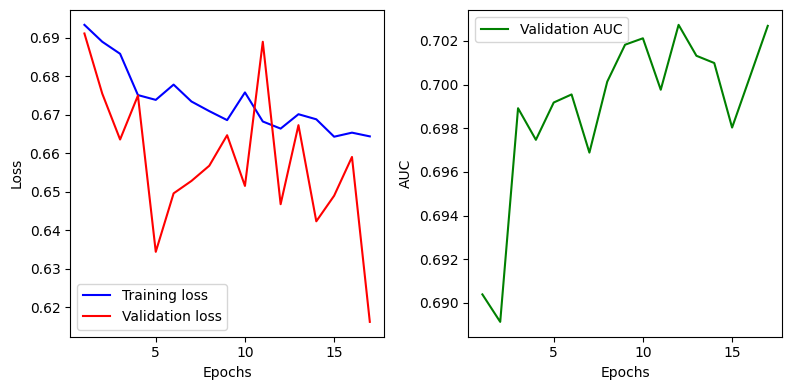

Best hyperparameters: {'hidden_dim': 128, 'layer_dim': 1, 'dropout_prob': 0.0, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.0001}

Best AUC: 0.702686893409376

Load the best hyperparameters with the best ROCAUC score on the validation set.

In [ ]:
best_params

{'hidden_dim': 128,
 'layer_dim': 1,
 'dropout_prob': 0.0,
 'learning_rate': 0.001,
 'batch_size': 64,
 'num_epochs': 50,
 'sampling_method': 'undersample',
 'loss': 'normal',
 'weight_decay': 0.0001}

### **Train model with best params on the full training set**

Now we have the best hyperparameters we can initialise a model and train on the training data.

In [ ]:
final_model = LSTMModel(
    input_dim=train_sequences.shape[2],
    hidden_dim=best_params['hidden_dim'],
    layer_dim=best_params['layer_dim'],
    output_dim=1,
    dropout_prob=best_params['dropout_prob'],
).to(device)

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'oversampling':
    train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences, train_labels)
elif best_params['sampling_method'] == 'undersampling':
    train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences, train_labels)
else:
    train_sequences_resampled, train_labels_resampled = train_sequences, train_labels


# Define the loss function
if best_params['loss'] == 'weighted':
    pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    criterion = nn.BCELoss()

# Define the optimizer with learning rate and L2 weight decay
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
train_loader, _, test_loader = create_data_loaders(
    train_sequences_resampled, train_labels_resampled,
    _, _,
    test_sequences, test_labels,
    batch_size=best_params['batch_size']
)

In [ ]:
# Train the model on the whole training set
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    best_params['num_epochs'],
    device
)

Epoch 1/50, Loss: 0.6382
Epoch 2/50, Loss: 0.6262
Epoch 3/50, Loss: 0.6163
Epoch 4/50, Loss: 0.6106
Epoch 5/50, Loss: 0.6092
Epoch 6/50, Loss: 0.6123
Epoch 7/50, Loss: 0.6081
Epoch 8/50, Loss: 0.6109
Epoch 9/50, Loss: 0.6066
Epoch 10/50, Loss: 0.6073
Epoch 11/50, Loss: 0.6100
Epoch 12/50, Loss: 0.6079
Epoch 13/50, Loss: 0.6058
Epoch 14/50, Loss: 0.6047
Epoch 15/50, Loss: 0.6088
Epoch 16/50, Loss: 0.6052
Epoch 17/50, Loss: 0.6031
Epoch 18/50, Loss: 0.6042
Epoch 19/50, Loss: 0.6056
Epoch 20/50, Loss: 0.6049
Epoch 21/50, Loss: 0.6041
Epoch 22/50, Loss: 0.6024
Epoch 23/50, Loss: 0.6050
Epoch 24/50, Loss: 0.6070
Epoch 25/50, Loss: 0.6036
Epoch 26/50, Loss: 0.6033
Epoch 27/50, Loss: 0.6056
Epoch 28/50, Loss: 0.6036
Epoch 29/50, Loss: 0.6027
Epoch 30/50, Loss: 0.6040
Epoch 31/50, Loss: 0.6044
Epoch 32/50, Loss: 0.6017
Epoch 33/50, Loss: 0.6033
Epoch 34/50, Loss: 0.6027
Epoch 35/50, Loss: 0.6044
Epoch 36/50, Loss: 0.6045
Epoch 37/50, Loss: 0.6025
Epoch 38/50, Loss: 0.6019
Epoch 39/50, Loss: 0.

Epoch 1/20, Loss: 0.6471
Epoch 2/20, Loss: 0.6328
Epoch 3/20, Loss: 0.6252
Epoch 4/20, Loss: 0.6162
Epoch 5/20, Loss: 0.6136
Epoch 6/20, Loss: 0.6120
Epoch 7/20, Loss: 0.6106
Epoch 8/20, Loss: 0.6107
Epoch 9/20, Loss: 0.6090
Epoch 10/20, Loss: 0.6081
Epoch 11/20, Loss: 0.6114
Epoch 12/20, Loss: 0.6081
Epoch 13/20, Loss: 0.6066
Epoch 14/20, Loss: 0.6071
Epoch 15/20, Loss: 0.6067
Epoch 16/20, Loss: 0.6075
Epoch 17/20, Loss: 0.6070
Epoch 18/20, Loss: 0.6065
Epoch 19/20, Loss: 0.6071
Epoch 20/20, Loss: 0.6072

In [ ]:
# Save final model in pickle file
final_model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/run_2/experiment_1/final_model.pkl'
with open(final_model_path, 'wb') as f:
    pickle.dump(final_model, f)

In [ ]:
# Evaluate the final model
evaluate_model(final_model, test_loader, device)

Accuracy: 0.3284
Precision: 0.3284
Recall (Sensitivity): 1.0000
F1 Score: 0.4944
ROC AUC: 0.5043
Specificity: 0.0000


(0.3283740701381509,
 0.3283740701381509,
 1.0,
 0.49439999999999995,
 0.5043064602023678,
 0.0)

Accuracy: 0.3284

Precision: 0.3284

Recall (Sensitivity): 1.0000

F1 Score: 0.4944

ROC AUC: 0.5043

Specificity: 0.0000

In [ ]:
# Calculate the F1 on the minority class
f1_minority = calculate_f1_minority(final_model, test_loader, device)
print(f"F1 Score on Minority Class: {f1_minority}")

F1 Score on Minority Class: 0.49439999999999995


Plot ROCAUC curve

In [ ]:
def plot_roc_curve(model, test_sequences, test_labels, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_sequences (numpy.array): The test sequences data.
    test_labels (numpy.array): The true labels for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """

    # Ensure test_sequences is a numpy array and then convert it to a PyTorch tensor
    test_sequences_tensor = torch.tensor(test_sequences, dtype=torch.float32).to(device)

    # Ensure the model is in evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        predictions = model(test_sequences_tensor)

    # Extract predictions as a numpy array
    predictions_np = predictions.cpu().numpy().flatten()

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions_np)

    # Plot ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

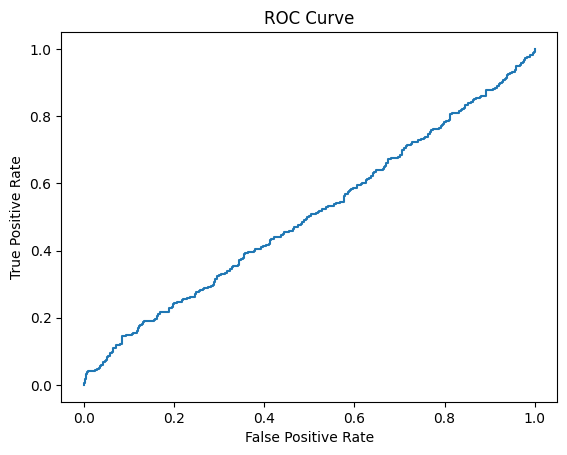

In [ ]:
plot_roc_curve(final_model, test_sequences, test_labels, device)

With sensitivity = 1 and specificity = 0 this indicates that all patients in the test set are being predicted as with the same class.

Let's analyse the predictions.



**Analysis of predictions**

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
original_class_counts = analyze_class_distribution(test_sequences, test_labels)
print("Normal sampling distribution", original_class_counts)

oversampled_sequences, oversampled_labels = oversample_data(test_sequences, test_labels)
oversampled_class_counts = analyze_class_distribution(oversampled_sequences, oversampled_labels)
print("Oversampling distribution", oversampled_class_counts)

undersampled_sequences, undersampled_labels = undersample_data(test_sequences, test_labels)
undersampled_class_counts = analyze_class_distribution(undersampled_sequences, undersampled_labels)
print("Undersampling distribution", undersampled_class_counts)

Normal sampling distribution Counter({0.0: 632, 1.0: 309})
Oversampling distribution Counter({1.0: 632, 0.0: 632})
Undersampling distribution Counter({0.0: 309, 1.0: 309})


The class imbalance is as expected in normal, under and oversampling.

The low accuracy and ROC AUC could indicate the model is overfitting the training data and failing to generalize to the test data. Regularization techniques such as dropout, weight decay, and early stopping can help mitigate overfitting (these are all being applied).

It is interesting that the model is over predicting the minority class.


In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  0 632]
 [  0 309]]


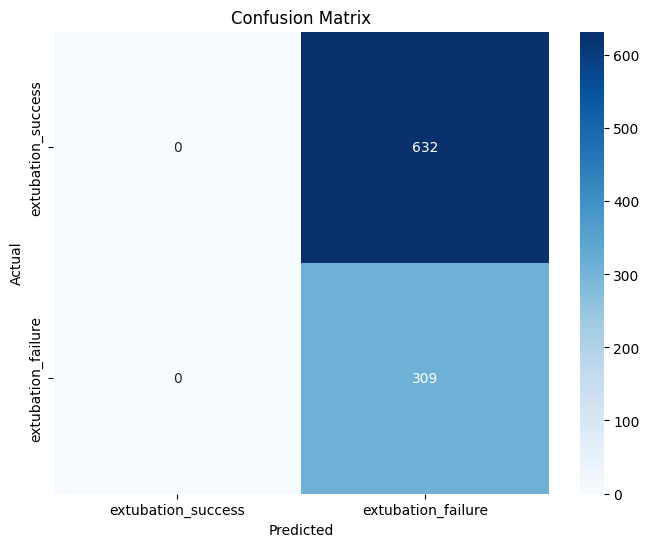

In [ ]:
# Plot confusion matrix
class_names = ['extubation_success', 'extubation_failure']
plot_confusion_matrix(cm, class_names)

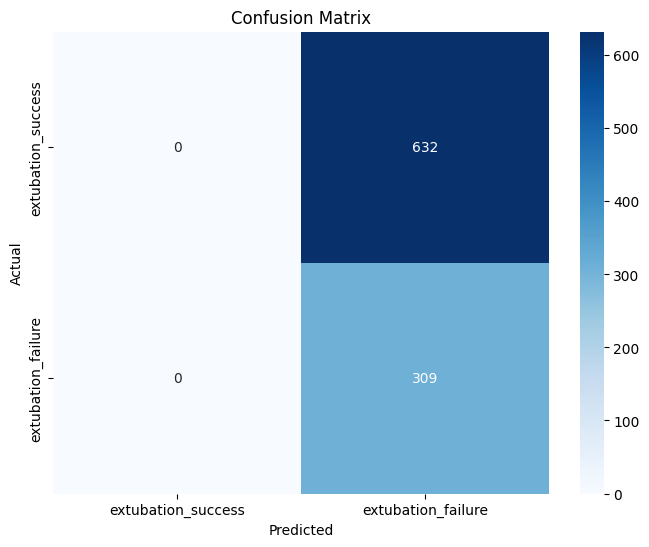

Checking there is no similarlity between the train and test sets i.e. data leakage

In [ ]:
def hash_sequence(sequence):
    """Convert a sequence to a hashable type (tuple of tuples)."""
    return tuple(map(tuple, sequence))

def check_sequence_overlap(train_sequences, test_sequences):
    """Check for overlapping sequences between training and testing datasets."""
    # Convert sequences to hashable types
    train_sequences_hashed = set(map(hash_sequence, train_sequences))
    test_sequences_hashed = set(map(hash_sequence, test_sequences))

    # Find common sequences
    common_sequences = train_sequences_hashed.intersection(test_sequences_hashed)

    # Number of common sequences
    num_common_sequences = len(common_sequences)

    return num_common_sequences, common_sequences

In [ ]:
num_common_sequences, common_sequences = check_sequence_overlap(train_sequences, test_sequences)
print(f"Number of common sequences: {num_common_sequences}")
if num_common_sequences > 0:
    print("Common sequences:")
    for sequence in common_sequences:
        print(sequence)

Number of common sequences: 0


Comparing statistics between the train and test sets to see if there are any large differences in features.

In [ ]:
def compare_statistics(train_sequences, test_sequences, feature_names):
    """
    Compare the statistics (mean and variance) of features in the training and test datasets.

    Parameters:
    train_sequences (np.ndarray): Training dataset sequences.
    test_sequences (np.ndarray): Test dataset sequences.
    feature_names (list): List of feature names.

    Returns:
    pd.DataFrame: A DataFrame containing the mean and variance of each feature in the training and test datasets.
    """
    # Calculate means and variances for the training data
    train_means = np.mean(train_sequences, axis=(0, 1))
    train_variances = np.var(train_sequences, axis=(0, 1))

    # Calculate means and variances for the test data
    test_means = np.mean(test_sequences, axis=(0, 1))
    test_variances = np.var(test_sequences, axis=(0, 1))

    # Create a DataFrame to compare the statistics
    stats_comparison = pd.DataFrame({
        'Feature': feature_names,
        'Train Mean': train_means,
        'Test Mean': test_means,
        'Train Variance': train_variances,
        'Test Variance': test_variances
    })

    # Print the statistics comparison

    return stats_comparison

In [ ]:
stats_comparison = compare_statistics(train_sequences, test_sequences, feature_names)
stats_comparison

,Feature,Train Mean,Test Mean,Train Variance,Test Variance
0,Inspired O2 Fraction,0.392570,0.783040,0.011626,0.035582
1,Tidal Volume (observed),0.382295,0.395307,0.019990,0.010776
2,Tidal Volume (spontaneous),0.371517,0.391498,0.019359,0.021246
3,Minute Volume,0.657040,0.381231,0.011013,0.019334
4,Peak Insp. Pressure,0.268072,0.662538,0.008740,0.010489
5,Respiratory Rate,0.314215,0.267942,0.007245,0.008164
6,O2 saturation pulseoxymetry,0.791135,0.311952,0.033086,0.007370
7,Arterial O2 pressure,0.459805,0.460872,0.003097,0.003814
8,Arterial CO2 Pressure,0.480821,0.480208,0.003885,0.003677
9,PH (Arterial),0.591268,0.590583,0.003939,0.004004


In [ ]:
def plot_feature_statistics_comparison(stats_comparison):
    features = stats_comparison['Feature']
    train_means = stats_comparison['Train Mean']
    test_means = stats_comparison['Test Mean']
    train_variances = stats_comparison['Train Variance']
    test_variances = stats_comparison['Test Variance']

    x = range(len(features))

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.bar(x, train_means, width=0.4, label='Train Mean', align='center')
    plt.bar(x, test_means, width=0.4, label='Test Mean', align='edge')
    plt.xticks(x, features, rotation='vertical')
    plt.ylabel('Mean')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.bar(x, train_variances, width=0.4, label='Train Variance', align='center')
    plt.bar(x, test_variances, width=0.4, label='Test Variance', align='edge')
    plt.xticks(x, features, rotation='vertical')
    plt.ylabel('Variance')
    plt.legend()

    plt.tight_layout()
    plt.show()

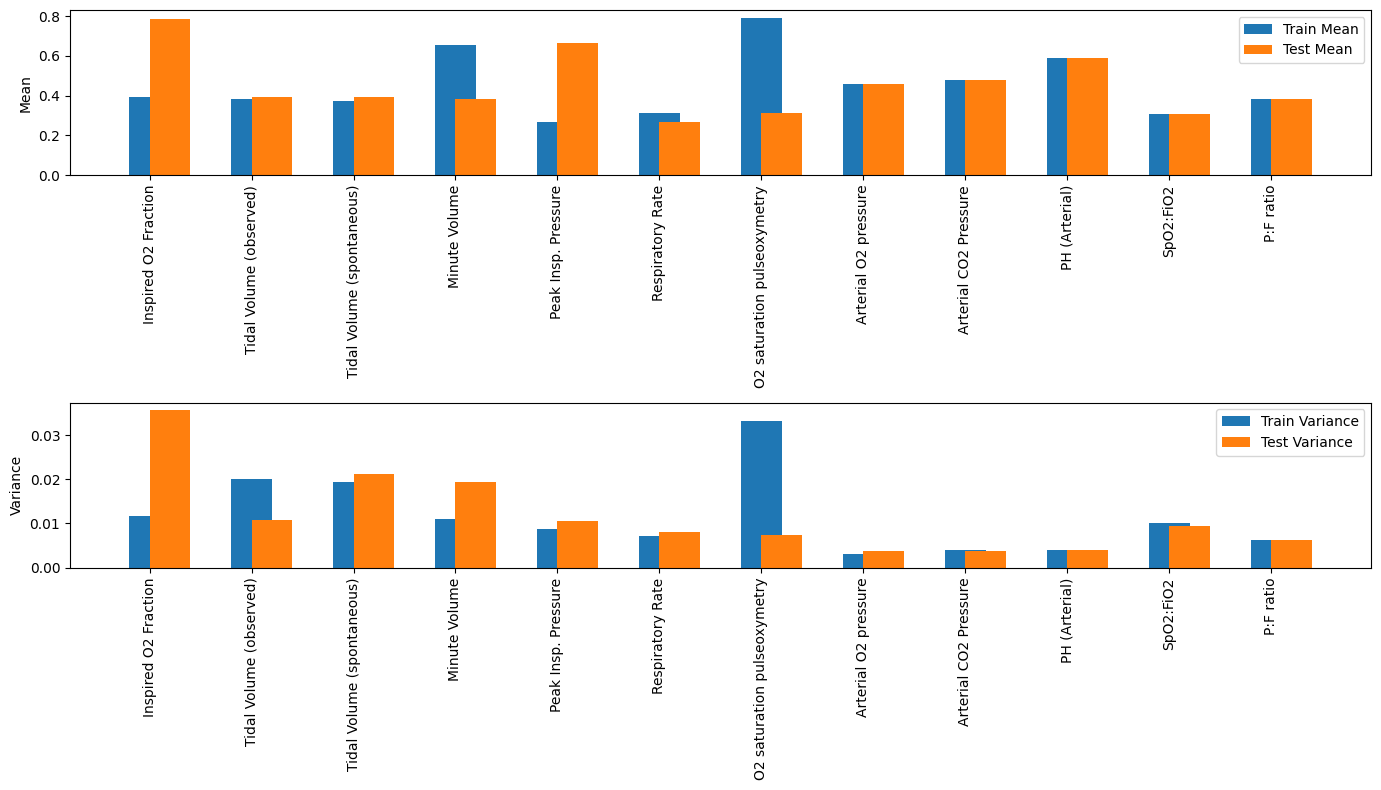

In [ ]:
plot_feature_statistics_comparison(stats_comparison)

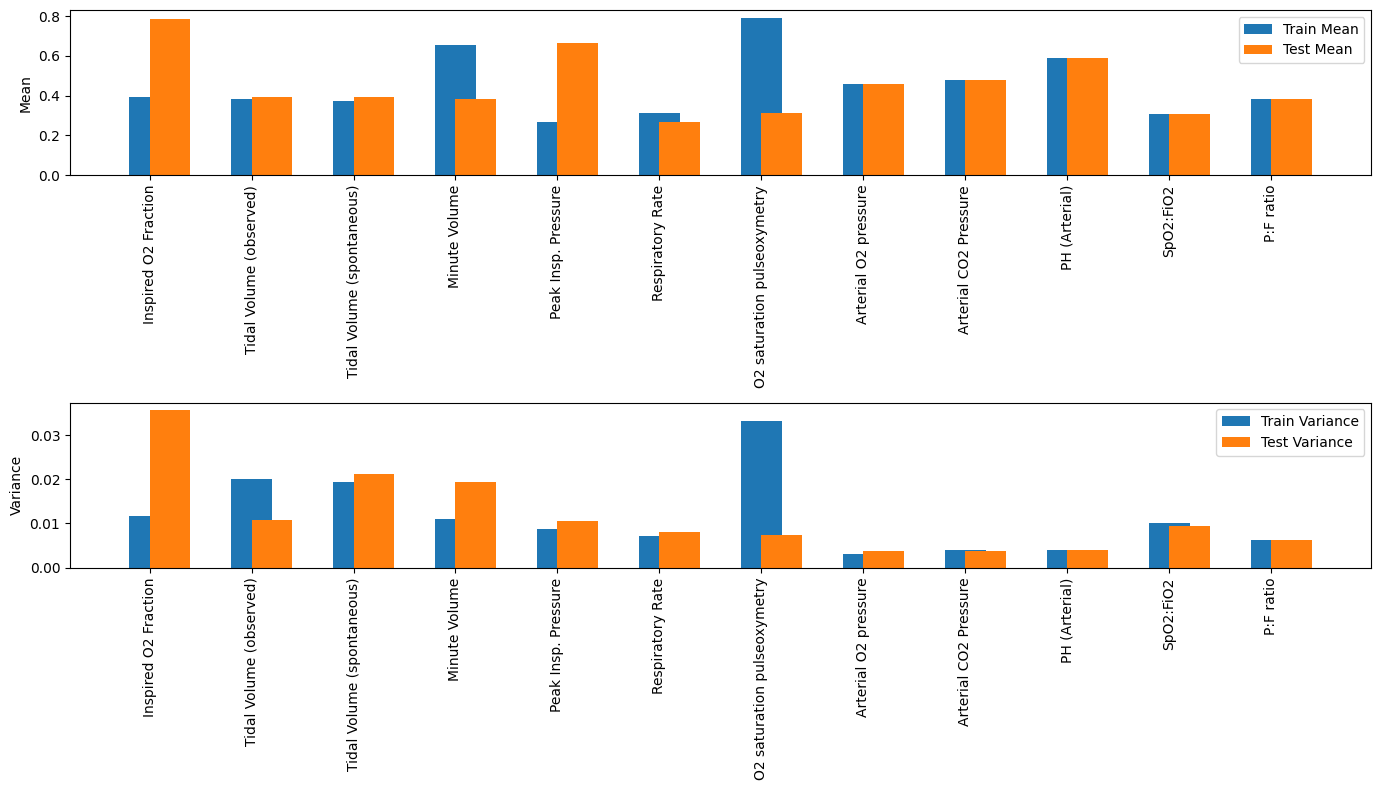

There seems to be some discrepancies between the train and test set in terms of the means and variances. However, this is not really something that can be pre-determined. The patients were split 80/20 ensuring that the amount of data that would need to be synthesised is comparable.

**Classification threshold**

The model is currently using a threshold of classification of 0.5. It may be the case that the threshold is not 0.5 and another value is relevant.

In [ ]:
final_model.eval()  # Set the model to evaluation mode

all_probs = []
all_labels = []

with torch.no_grad():
    for i in range(len(test_sequences)):
        sequence = test_sequences[i]
        label = test_labels[i]

        # Convert sequence to torch tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device)

        # Get model output (predicted probabilities)
        output = final_model(sequence_tensor)

        # Append predicted probabilities and true labels
        all_probs.extend(output.cpu().numpy().flatten())
        all_labels.extend([label])

# Convert lists to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

In [ ]:
best_threshold = 0.5
best_metric_value = 0.0

thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

for threshold in thresholds:
    preds = (all_probs >= threshold).astype(int)
    # Choose the metric you want to optimize. Here, let's use F1 score as an example
    metric_value = roc_auc_score(all_labels, preds)

    if metric_value > best_metric_value:
        best_metric_value = metric_value
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}")
print(f"Best Metric Value: {best_metric_value}")

Best Threshold: 0.81
Best Metric Value: 0.5260307853017082


Based on ROC AUC the best threshold is 0.81 which is extremely high and unlikley to ever be applicable in the real world.

In [ ]:
final_preds = (all_probs >= best_threshold).astype(int)

# Calculate the final evaluation metrics
accuracy = accuracy_score(all_labels, final_preds)
precision = precision_score(all_labels, final_preds)
recall = recall_score(all_labels, final_preds)
f1 = f1_score(all_labels, final_preds)
roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
specificity = recall_score(all_labels, final_preds, pos_label=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.6599
Precision: 0.4421
Recall: 0.1359
F1 Score: 0.2079
ROC AUC: 0.5043
Specificity: 0.9161


Even with an optimium threshold, the model has poor performance - the performance is only just better than random guessing.

**Investigate model predictions and weights**

We can check if the model weights are being updated properly during training.

In [ ]:
for name, param in final_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[ 0.0015, -0.0092, -0.0085,  ..., -0.0020, -0.0159, -0.0120],
        [ 0.0253, -0.0230, -0.0210,  ..., -0.0039, -0.0425, -0.0234],
        [ 0.0056,  0.0115,  0.0063,  ...,  0.0023,  0.0129,  0.0085],
        ...,
        [-0.0050,  0.0025, -0.0038,  ..., -0.0050, -0.0050, -0.0050],
        [-0.0187, -0.0397, -0.0383,  ...,  0.0130, -0.0356, -0.0410],
        [ 0.0040,  0.0166,  0.0031,  ...,  0.0052,  0.0216,  0.0058]],
       device='cuda:0')
lstm.weight_hh_l0 tensor([[-0.0002, -0.0003,  0.0005,  ...,  0.0011, -0.0004,  0.0007],
        [ 0.0008, -0.0030,  0.0034,  ...,  0.0017,  0.0034,  0.0025],
        [ 0.0011, -0.0019,  0.0005,  ...,  0.0003,  0.0024, -0.0007],
        ...,
        [ 0.0009, -0.0024, -0.0002,  ...,  0.0011,  0.0009, -0.0004],
        [ 0.0004, -0.0020,  0.0021,  ...,  0.0011, -0.0079, -0.0002],
        [ 0.0015, -0.0026, -0.0002,  ...,  0.0025,  0.0029, -0.0049]],
       device='cuda:0')
lstm.bias_ih_l0 tensor([-0.0312,  0.0065,  0.010

The issue is clearly within the data itself. All possible measures to imporve model performance have been implemented and do not seem to make a difference.

We will continue to look at interpretability now.

### **Model interpretability**

**Feature Ablation**

We will now carry out feature ablation on this model and see how the each feature influences model performance.

Definition - A perturbation based approach to computing attribution, involving replacing each input feature with a given baseline / reference, and computing the difference in output (https://captum.ai/api/feature_ablation.html)

Feature ablation is carried out by removing the feature and training the model and seeing how that impacts evaluation scores. The other method of just setting the value to 0 is not being considered as this is more comprehensive.

Ablating feature Inspired O2 Fraction (1/12)
Epoch 0/49, Loss: 0.6368, Val Loss: 0.6334, Val AUC: 0.6243
Epoch 1/49, Loss: 0.6265, Val Loss: 0.6388, Val AUC: 0.6364
Epoch 2/49, Loss: 0.6244, Val Loss: 0.6124, Val AUC: 0.6368
Epoch 3/49, Loss: 0.6153, Val Loss: 0.6117, Val AUC: 0.6372
Epoch 4/49, Loss: 0.6093, Val Loss: 0.6055, Val AUC: 0.6382
Epoch 5/49, Loss: 0.6093, Val Loss: 0.6047, Val AUC: 0.6396
Epoch 6/49, Loss: 0.6083, Val Loss: 0.6045, Val AUC: 0.6410
Epoch 7/49, Loss: 0.6076, Val Loss: 0.6078, Val AUC: 0.6413
Epoch 8/49, Loss: 0.6070, Val Loss: 0.6063, Val AUC: 0.6413
Epoch 9/49, Loss: 0.6065, Val Loss: 0.6071, Val AUC: 0.6418
Epoch 10/49, Loss: 0.6090, Val Loss: 0.6053, Val AUC: 0.6432
Epoch 11/49, Loss: 0.6069, Val Loss: 0.6027, Val AUC: 0.6437
Epoch 12/49, Loss: 0.6068, Val Loss: 0.6043, Val AUC: 0.6440
Epoch 13/49, Loss: 0.6077, Val Loss: 0.6041, Val AUC: 0.6450
Epoch 14/49, Loss: 0.6056, Val Loss: 0.6057, Val AUC: 0.6443
Epoch 15/49, Loss: 0.6070, Val Loss: 0.6030, Val A

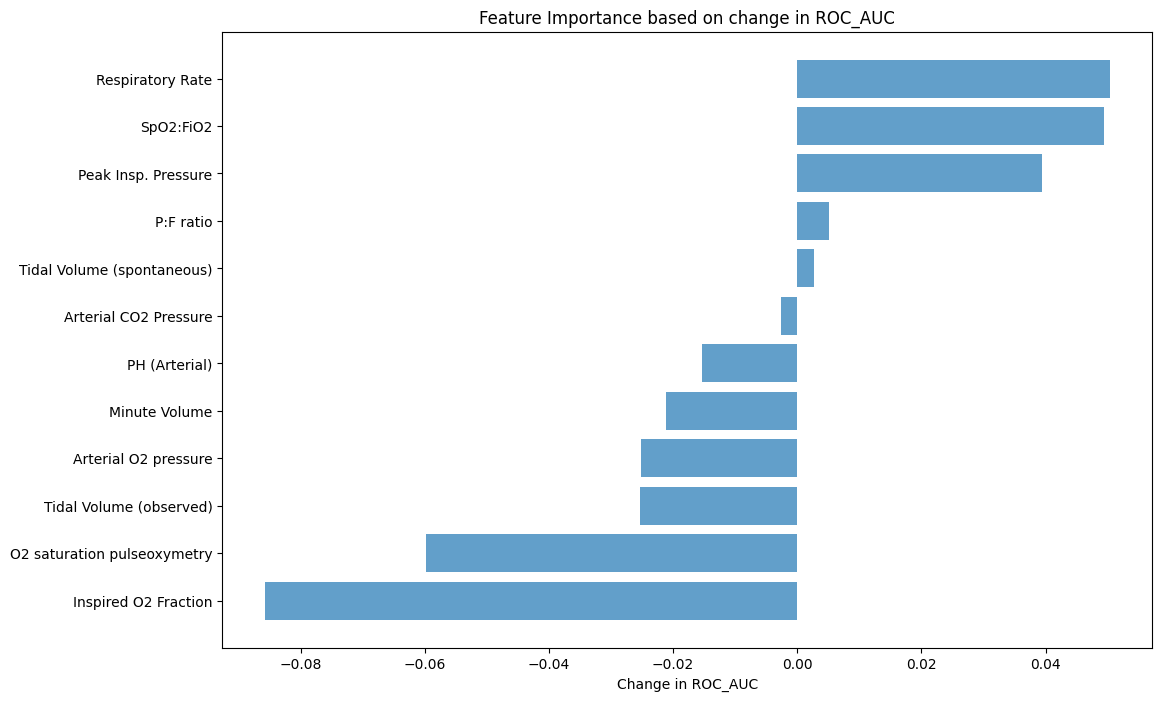

In [ ]:
feature_importances = feature_ablation_with_names(train_sequences, train_labels, test_sequences, test_labels, final_model, best_params, device, feature_names)

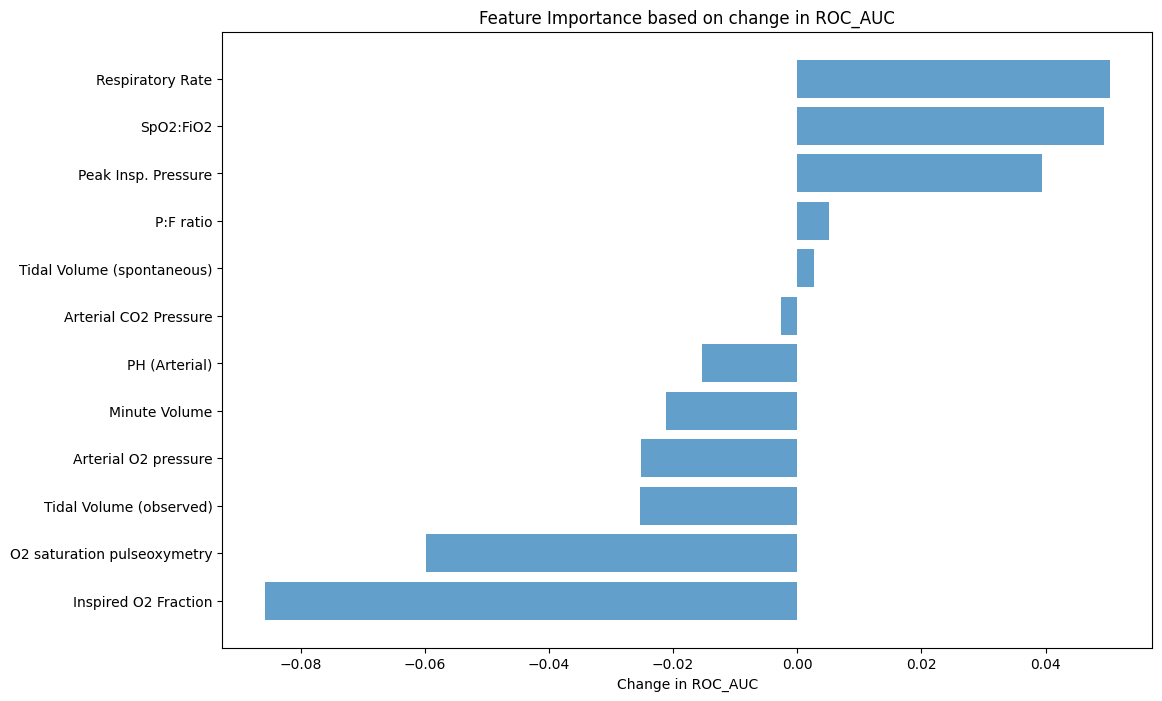

There seem to be a number of features that negatively impacted the model's ability to predict.

The most important features were FiO2 and PaO2.

It should be noted that the changes in ROCAUC either way are very small highlighting that the model was not very sensitive to the features.